In [1]:
#May 25

import ares
import numpy as np
import matplotlib.pyplot as pl

In [5]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

### DPL SMF relation  
Following from Moster2010

In [40]:
def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma):
    
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) )
#     print(mM_ratio)
    
    #is this right?
    SMF = pop_halo.halos.tab_dndm[i, :] * mM_ratio #HMF * m/M

    return SMF,  mM_ratio

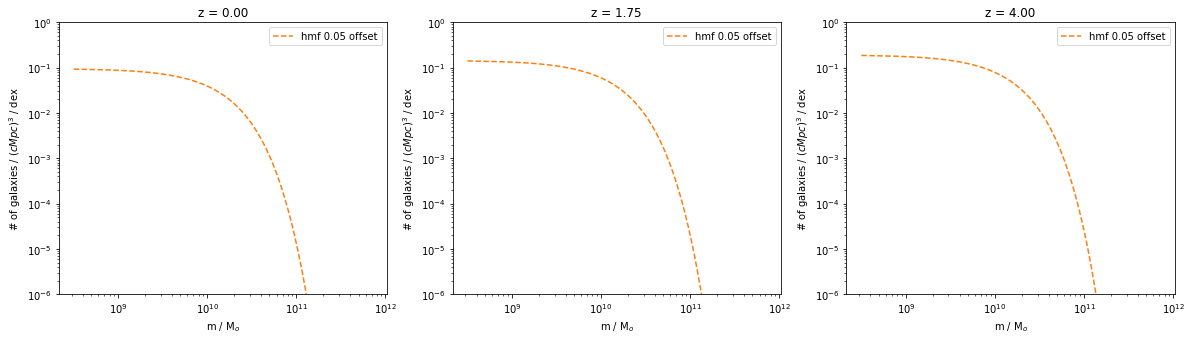

In [65]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

#From Moster2010, table 1
N = 0.02820
M_1 = 10**11.884 #np.exp(11.884) # was this stated in e or base 10?
beta = 1.057
gamma = 0.557

for i, z in enumerate([0, 1.75, 4]):
   
#     data.PlotSMF(z=z, round_z=0.2, ax=axs[i])

#     for c in [1e-4, 1, 1e2, 1e3, 1e4]:
    SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)

    SM = np.linspace(10**8.5, 10**11.85, num=len(SMF))
#     SM = pop_halo.halos.tab_M

    axs[i].loglog(SM, SMF)#, label='c = %.e' %c)
    
    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    axs[i].loglog(SM, pop_halo.halos.tab_dndm[zz, :]*0.05, ls = "--", label='hmf 0.05 offset')

        
    axs[i].set_title("z = %.2f" %z)
    axs[i].legend()
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
#     axs[i].set_xlim(-35, 0)

pl.show()

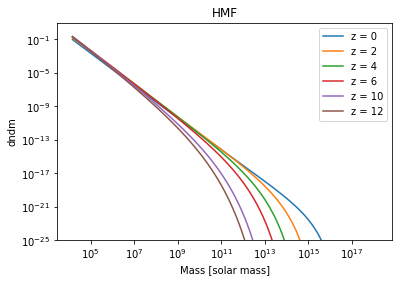

In [41]:
for z in [0, 2, 4, 6, 10, 12]:
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z)) #Returns the indices of the min value (so with z-zArray, this min value corresponds to the value closest to z)

    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*0.05, label='z = %i' %z)
    
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-25, 10)
pl.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


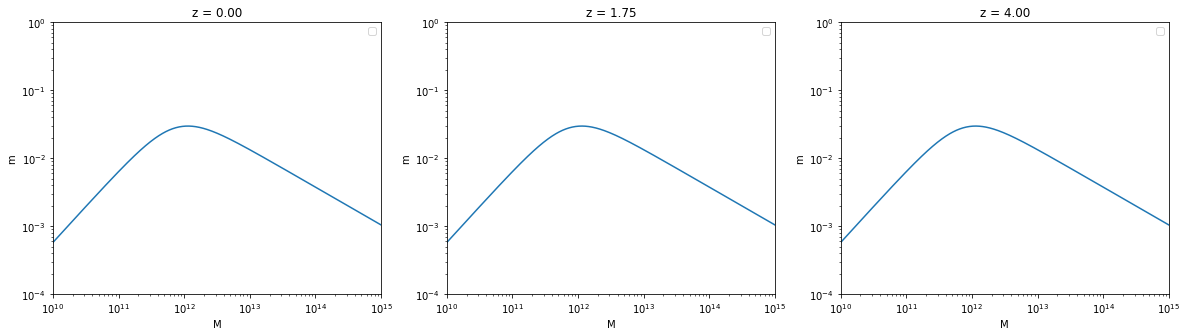

In [75]:
#looking at the SHM ratio m/M

fig, axs = pl.subplots(1, 3, figsize=(20, 5))

for i, z in enumerate([0, 1.75, 4]):
   
#     data.PlotSMF(z=z, round_z=0.2, ax=axs[i])

#     for c in [1e-4, 1, 1e2, 1e3, 1e4]:
    SMF, ratio = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma) #* pop_halo.halos.tab_M

#     SM = np.linspace(1e8, 1e12, num=len(SMF))
    SM = pop_halo.halos.tab_M

    axs[i].loglog(SM, ratio)#, label='c = %.e' %c)
        
    axs[i].set_title("z = %.2f" %z)
    axs[i].legend()
    axs[i].set(xlabel='M', ylabel='m')
    axs[i].set_ylim(1e-4, 1e0)
    axs[i].set_xlim(1e10, 1e15)

pl.show()

In [64]:
print("%.e" %np.exp(11.884))

1e+05
